Given an image, a depth map, a mask, camera information and a distance from the
camera, predict occupancies, i.e., which part of the 3D space is occupied by a
human body. For some more details see https://arxiv.org/abs/2208.02817. The
provided data enables you to construct ground truth for this task and develop
your favorite model. Enjoy.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pwd

/content


In [3]:
%cd drive/MyDrive/ECE 544 Project/"VincentsWorkspace"

/content/drive/MyDrive/ECE 544 Project/VincentsWorkspace


In [4]:
import os
os.chdir("/content/drive/MyDrive/ECE 544 Project/VincentsWorkspace")
import sys
sys.path.append(".")
%autosave 60

Autosaving every 60 seconds


In [ ]:
!ls

binvox_rw.py		 demodata      meshobj.py		__pycache__
DataVisualization.ipynb  demodata.tgz  Project_Workspace.ipynb


In [5]:
!pip install trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 669 kB 4.0 MB/s 


In [ ]:
!git clone https://github.com/skoch9/meshplot.git

fatal: destination path 'meshplot' already exists and is not an empty directory.


In [ ]:
!python setup.py install

python: can't open file 'setup.py': [Errno 2] No such file or directory


In [7]:
import numpy as np
import sys
import torch
#from meshobj import MeshObj

In [8]:
pixel_mean = np.array([123.675, 116.280, 103.530]).reshape((1, 1, 3))
pixel_std = np.array([58.395, 57.120, 57.375]).reshape((1, 1, 3))
#max_depth_range = 2.1
n_planes_for_train = 5
n_planes_for_val = 20
n_bins_for_plane_hrchy_sampling = 20
mesh_data_root = 'demodata'
data_h = 512
data_w = 512
crop_expand_ratio = 0.1
binvoxPathPrefix = 'demodata'
use_adaptive_sampling = False
bin_sample_replace = False
depth_range_expand_ratio = 0.1
use_masked_out_img = False
extra_mesh_data_root = None

In [9]:
folder = 'demodata/'
obj_list = []
with open(folder+'data.txt') as f:
    lines = f.read().splitlines()
    #obj_list.append(lines) 
line = lines[1].split(',')[0]
print(line)

./sol_3_int/0005_Ped_000001167167044_000000000263175_00/000087_mesh/mesh.obj


In [10]:
line = lines[344].split(',')[0]
print(line)

./fin_c_int/0002_Ped_000002602752943_000000000000002_00/000957_mesh/mesh.obj


In [15]:
import os
import sys
import gc
import glob
import multiprocessing
import trimesh
import traceback
import skimage
import numpy as np
import matplotlib.pyplot as plt
import meshplot as mp
from tqdm import tqdm
from PIL import Image
from scipy.ndimage.morphology import binary_erosion, distance_transform_edt
from scipy.ndimage import maximum_filter, gaussian_filter
from scipy import ndimage
from skimage import filters, transform  
import binvox_rw

import torch
from torch.utils.data import Dataset


class MeshObj:
    def __init__(self,fn, max_depth_range=None, fnroot="", binvoxPathPrefix='', extra_fnroot=None, pure_infer=False):
        self.float_type = np.float32
        arr = fn.split('/')
        self.csName = arr[-4]
        self.objID = int(arr[-3].split('_')[0])
        self.frameID = arr[-2].split('_')[0]
        self.IMAGE_SIZE = (800, 1280)
        self.fnroot = fnroot
        self.fn = self.fnroot + fn[1:]

        self.extra_fnroot = extra_fnroot
        if self.extra_fnroot is not None:
            self.extra_fn = self.extra_fnroot + fn[1:]
        else:
            self.extra_fn = None

        self.imfn = self.fnroot + '/{}/images/{}.bmp'.format(self.csName,self.frameID)
        if self.extra_fnroot is not None:
            self.depthfn = self.extra_fnroot + '/{}/depth/{}.npy'.format(self.csName,self.frameID)
            self.visfn = self.extra_fnroot + '/{}/visible/{}.npy'.format(self.csName,self.frameID)
        else:
            self.depthfn = self.fnroot + '/{}/depth/{}.npy'.format(self.csName,self.frameID)
            self.visfn = self.fnroot + '/{}/visible/{}.npy'.format(self.csName,self.frameID)
        
        self.pure_infer = pure_infer
        if not self.pure_infer:
            self.binvox = binvoxPathPrefix + self.GetObjFN()[1:-8] + 'voxel.binvox2'
            if not os.path.exists(self.binvox):
                self.binvox = self.binvox[:-1]
            if not os.path.exists(self.binvox):
                self.binvox = os.path.join(os.path.dirname(self.binvox), "voxel_256.binvox2")
            assert os.path.exists(self.binvox), f"{self.binvox}"

        self.LoadRMatrices()

        self.avoid_nan_eps = 1e-8
    
    def compute_visible_mesh_depth_range(self):
        xx, yy, xxi, yyi, select, obj = self.ProjectObjToImage()
        vis_verts = np.array(obj.vertices)[select, :]
        min_coords = np.min(vis_verts, axis=0)
        max_coords = np.max(vis_verts, axis=0)
        depth_range = max_coords[2] - min_coords[2]
        return depth_range, max_coords[2]
        
    def LoadRMatrices(self):
        if self.extra_fn is not None:
            rmatrices_file = sorted(glob.glob(self.extra_fn[:-8] + 'draw_*/rage_matrices_bin.csv'))[0]
        else:
            rmatrices_file = sorted(glob.glob(self.fn[:-8] + 'draw_*/rage_matrices_bin.csv'))[0]
    
        rage_matrices = np.fromfile(rmatrices_file,dtype=np.float32).astype(self.float_type)
        rage_matrices = rage_matrices.reshape((4,4,4))
        self.VP = np.dot(np.linalg.inv(rage_matrices[0,:,:]),rage_matrices[2,:,:])
        self.VP_inverse = np.linalg.inv(self.VP) # multiply this matrix to convert from NDC to world coordinate
        self.P = np.dot(np.linalg.inv(rage_matrices[1,:,:]),rage_matrices[2,:,:])
        self.P_inverse = np.linalg.inv(self.P) # multiply this matrix to convert from NDC to camera coordinate
    def GetObjFN(self):
        return "." + self.fn[len(self.fnroot):]
    def GetMesh(self):
        return trimesh.load(self.fn)
    def LoadBinVox(self):
        with open(self.binvox, 'rb') as f:
            return binvox_rw.read_as_3d_array(f)
    def ndcs_to_pixels(self, x, y):
        s_y, s_x = self.IMAGE_SIZE
        s_x -= 1
        s_y -= 1
        xx = self.float_type(x + 1) * self.float_type(s_x / 2)
        yy = self.float_type(1 - y) * self.float_type(s_y / 2)
        return xx, yy
    def pixels_to_ndcs(self, xx, yy):
        s_y, s_x = self.IMAGE_SIZE
        s_x -= 1  # so 1 is being mapped into (n-1)th pixel
        s_y -= 1  # so 1 is being mapped into (n-1)th pixel
        x = self.float_type(2 / s_x) * self.float_type(xx) - 1
        y = self.float_type(-2 / s_y) * self.float_type(yy) + 1
        return x, y
    def ProjectObjToImage(self):
        obj = trimesh.load(self.fn)
        ndcpts = np.concatenate([obj.vertices, np.ones((obj.vertices.shape[0],1))],axis=1) @ self.P
        ndcpts = ndcpts[:,0:2]/ndcpts[:,-1:]
        xx, yy = self.ndcs_to_pixels(ndcpts[:,0], ndcpts[:,1])
        xxi = np.rint(xx).astype(int)
        yyi = np.rint(yy).astype(int)
        select = np.logical_and(np.logical_and(xxi>0, xxi<self.IMAGE_SIZE[1]), np.logical_and(yyi>0, yyi<self.IMAGE_SIZE[0]))
        return xx, yy, xxi, yyi, select, obj
    
    def __repr__(self):
        return "MeshObj(\n  {}\n  {};  {};  {})".format(self.fn,self.csName,self.objID,self.frameID)
    def __str__(self):
        return self.__repr__()
    
    def PlotData(self,numDepth,given_depth_range=None,depth_range_expand_ratio=0.1,pure_infer=False):
        im = np.array(Image.open(self.imfn))
        plt.imshow(im)
        plt.show()
        depth = np.load(self.depthfn).astype(self.float_type)/6.0 - 4e-5
        plt.imshow(depth)
        plt.colorbar()
        plt.show()
        vis_orig = np.load(self.visfn)==self.objID
        plt.imshow(vis_orig)
        plt.show()

        obj = self.GetMesh()
        p = mp.plot(obj.vertices, shading={"point_color": "blue", "point_size": 0.03}, return_plot=True)
        p.add_edges(obj.vertices, obj.faces, shading={"line_color": "black"})

        py_orig, px_orig = np.nonzero(vis_orig)
        px = px_orig 
        py = py_orig 
        ndcx, ndcy = self.pixels_to_ndcs(px, py)
        ndcz = depth[py, px]
        rgb = im[py, px]

        ndc_coord = np.stack([ndcx, ndcy, ndcz, np.ones_like(ndcz)], axis=1) # NDC
        camera_coord = ndc_coord @ self.P_inverse # convert to camera coordinate, [#pixels, 3]
        camera_coord = camera_coord[:,0:3]/camera_coord[:,-1:] # divide, [#pixels, 3]

        mp.plot(camera_coord, c=rgb.astype(np.double)/255, shading={"point_size": 0.03})

        if given_depth_range is not None:
            cur_depth_range = given_depth_range
            if pure_infer:
                # NOTE: during inference, we heavily rely on mask to give correct closest_depth value.
                # Therefore, we need to be somehow conservative. 
                vis_for_max_Z = binary_erosion(vis_orig, np.ones((10, 10)))
                tmp_py_orig, tmp_px_orig = np.nonzero(vis_for_max_Z)
                tmp_px = tmp_px_orig 
                tmp_py = tmp_py_orig 
                tmp_ndcx, tmp_ndcy = self.pixels_to_ndcs(tmp_px, tmp_py)
                tmp_ndcz = depth[tmp_py, tmp_px]

                tmp_ndc_coord = np.stack([tmp_ndcx, tmp_ndcy, tmp_ndcz, np.ones_like(tmp_ndcz)], axis=1) # NDC
                tmp_camera_coord = tmp_ndc_coord @ self.P_inverse # convert to camera coordinate, [#pixels, 3]
                tmp_camera_coord = tmp_camera_coord[:,0:3] / tmp_camera_coord[:,-1:] # divide, [#pixels, 3]
                cur_closest_vis_depth = np.max(tmp_camera_coord[:, 2])
            else:
                raise NotImplementedError
        else:
            cur_depth_range, cur_closest_vis_depth = self.compute_visible_mesh_depth_range()
            cur_depth_range = cur_depth_range * (1 + depth_range_expand_ratio)


        maxZ = np.max(camera_coord[:, 2])    # neg-Z is for forward. Therefore, maxZ is the closest depth.
        aug = np.reshape(np.linspace(maxZ, maxZ - cur_depth_range, numDepth), (1, numDepth)).astype(self.float_type)

        with open(self.binvox, 'rb') as f:
            m1 = binvox_rw.read_as_3d_array(f)

        coords = np.tile(camera_coord[...,np.newaxis], (1, 1, numDepth))  # [#pixels, 3, num_depth]

        # Path along the ray
        coords = coords * aug[:, np.newaxis, :] / (camera_coord[:, 2:, np.newaxis] + self.avoid_nan_eps) # [#p, 3, #d], aug: [1, 1, #d], [#p, 1, 1], [#p, 1, #d]

        coords = np.swapaxes(coords,1,2)      # [#pixels, num_depth, 3]
        coords = np.reshape(coords, (-1,3))   # [#pixels x num_depth, 3]
        # ii = np.tile(np.arange(numDepth), (coords.shape[0]//numDepth,))  # [num_depth x #pixels, ]

        grid_coords = np.round((coords - m1.translate) / m1.scale * m1.dims - 0.5).astype(int)
        label = np.zeros((coords.shape[0],),dtype=bool)
        select = np.logical_and(np.all(grid_coords>=0,axis=1), np.all(grid_coords<m1.dims,axis=1))
        label[select] = m1.data[grid_coords[select,0], grid_coords[select,1], grid_coords[select,2]]

        p = mp.plot(obj.vertices, shading={"point_color": "blue", "point_size": 0.03}, return_plot=True)
        p.add_edges(obj.vertices, obj.faces, shading={"line_color": "black"})
        p.add_points(coords, c=label, shading={"point_color": "green", "point_size": 0.3})

        print("Given image, depth map, mask, camera information and depth of a plane, predict occupancies like the ones illustrated next:")

        gt_im = np.zeros(vis_orig.shape + (numDepth,), dtype=bool)   # [new_h, new_w, num_depth]
        #print(gt_im[0,:,:])

        for ii in range(numDepth):
            gt_im[py_orig, px_orig, ii] = label[ii::numDepth]
            plt.imshow(gt_im[:,:,ii])
            plt.show()

    def Get_GroundTruth(self,numDepth):
        vis_orig = np.load(self.visfn)==self.objID
        gt_im = np.zeros(vis_orig.shape + (numDepth,), dtype=bool) 
        for ii in range(numDepth):
            gt_im[py_orig, px_orig, ii] = label[ii::numDepth]
        return gt_im


In [21]:
data = MeshObj(line,None,mesh_data_root,binvoxPathPrefix,extra_mesh_data_root)
data.Get_GroundTruth(n_planes_for_train)
depth_range, max_z = data.compute_visible_mesh_depth_range()
min_z = max_z - depth_range
print(min_z)

-2.28851489


In [ ]:
!pip install -q condacolab

In [ ]:
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:36
🔁 Restarting kernel...


In [ ]:
!conda install -c conda-forge meshplot

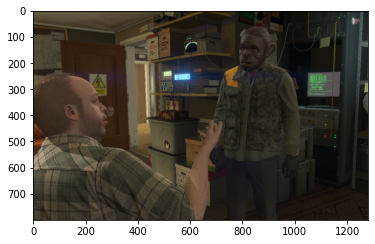

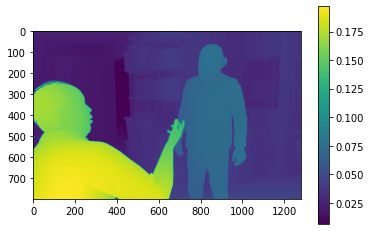

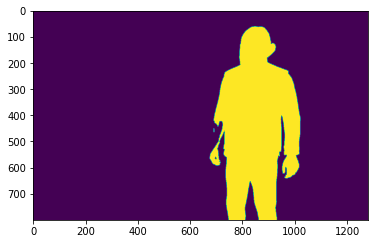

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.3852726…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.3870320…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.3852726…

Given image, depth map, mask, camera information and depth of a plane, predict occupancies like the ones illustrated next:


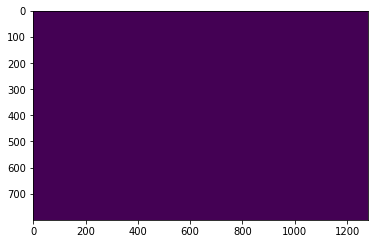

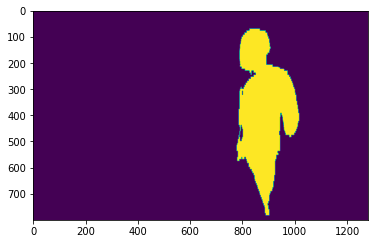

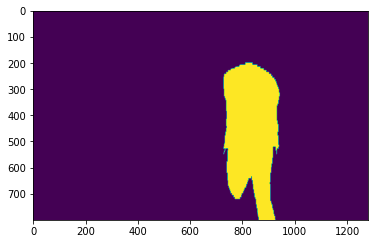

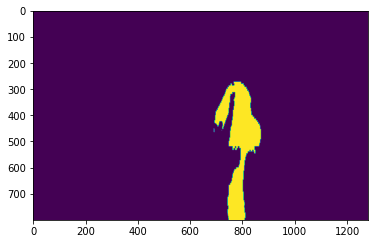

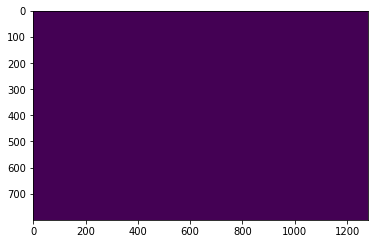

In [ ]:
data.PlotData(n_planes_for_train)